In [2]:
import cv2
import numpy as np

def threshold_video_movement(video_path: str) -> np.ndarray:
    """
    Detect significant changes in a video using background subtraction and thresholding.
    Args:
        video_path: Path to the video file.
    Returns:
        A thresholded image highlighting significant changes in the video.
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # Create a background subtractor object
    backSub = cv2.createBackgroundSubtractorMOG2(history=10, varThreshold=40, detectShadows=False)

    # Initialize variables
    accumulated_mask = None
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Apply background subtraction to get the foreground mask
        fg_mask = backSub.apply(frame)

        # if more than 20% of the frame is moving, this is a significant change, and we break and don't accumulate
        #print(np.count_nonzero(fg_mask))
        if frame_count != 0 and np.count_nonzero(fg_mask) > 0.1 * fg_mask.size:
            break

        # Initialize the accumulated mask with the same size as fg_mask
        if accumulated_mask is None:
            accumulated_mask = np.zeros_like(fg_mask, dtype=np.float32)

        # Accumulate the foreground masks
        accumulated_mask += fg_mask.astype(np.float32)
        frame_count += 1

    cap.release()

    # Normalize the accumulated mask
    accumulated_mask /= frame_count

    # Convert accumulated mask to 8-bit image
    accum_mask_uint8 = cv2.normalize(accumulated_mask, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply adaptive thresholding (Binary Threshold method) to find significant changes
    _, thresholded_image = cv2.threshold(accum_mask_uint8, 0, 255, cv2.THRESH_BINARY)

    # Return the thresholded image highlighting significant changes
    return thresholded_image

output_image = threshold_video_movement('videos/new_fiducials.mjpeg')
#output_image = detect_clogged_nozzles('test2_0920.mjpeg')
cv2.imwrite('new_fidu_output.png', output_image)

True

In [3]:
pts_src = np.array([
    [345, 210],  # Top-left
    [805, 330],  # Top-right
    [350, 360],  # Bottom-left
    [805, 430]   # Bottom-right
], dtype=float)

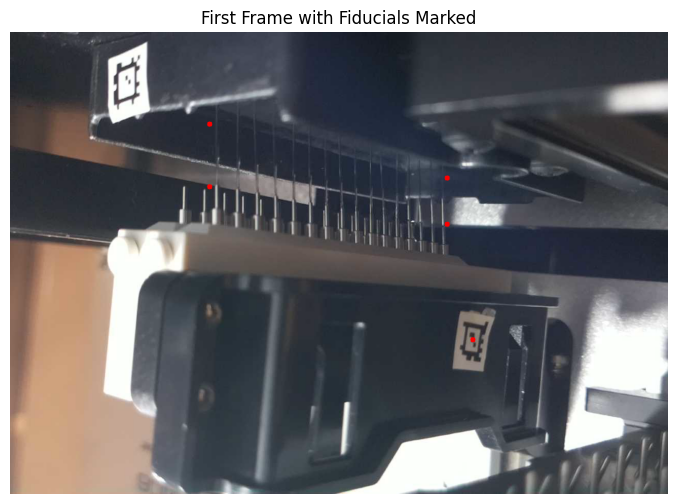

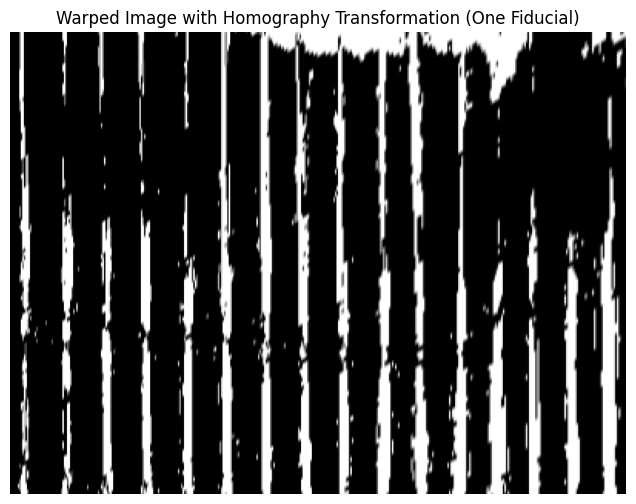

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from robotpy_apriltag import AprilTagDetector as apriltag

class Position:
    def __init__(self, x, y):
        self.x = x
        self.y = y

# Step 1: Extract Fiducial Marker Coordinates from First Frame
def locate_and_calculate_homography(video_path, image_path):
    cap = cv2.VideoCapture(video_path)
    ret, first_frame = cap.read()
    cap.release()
    if not ret:
        raise FileNotFoundError(f"Could not read the video at path: {video_path}")

    gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
    detector = apriltag()
    detector.addFamily("tagStandard41h12")
    detections = detector.detect(gray)
    if len(detections) == 0:
        raise ValueError("No fiducials detected in the video frame.")

    # Assuming only one fiducial is used for homography calculation
    detection = detections[0]
    center = detection.getCenter()
    fiducial_coord = Position(center.x, center.y)

    # Debug: Draw fiducial on the first frame
    cv2.circle(first_frame, (int(center.x), int(center.y)), 5, (0, 0, 255), -1)
    for i, (label, point) in enumerate([('Top-left', (center.x - 512, center.y - 420)),
                                        ('Top-right', (center.x - 50, center.y - 315)),
                                        ('Bottom-left', (center.x - 512, center.y - 298)),
                                        ('Bottom-right', (center.x - 50, center.y - 225))]):
        cv2.circle(first_frame, (int(point[0]), int(point[1])), 5, (0, 0, 255), -1)
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))
    plt.title("First Frame with Fiducials Marked")
    plt.axis('off')
    plt.show()
      # Step 2: Calculate Homography Using One Fiducial
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load the image at path: {image_path}")
    
    x, y = fiducial_coord.x, fiducial_coord.y
    
    pts_src = np.array([
        [x - 512, y - 420],  # Top-left (relative offset from fiducial)
        [x - 50, y - 315],   # Top-right
        [x - 512, y - 298],  # Bottom-left
        [x - 50, y - 225]    # Bottom-right
    ], dtype=float)
    
    width = 400
    height = 300
    pts_dst = np.array([
        [0, 0],            # Top-left
        [width - 1, 0],    # Top-right
        [0, height - 1],   # Bottom-left
        [width - 1, height - 1]  # Bottom-right
    ], dtype=float)
    
        # Calculate the homography matrix
    homography_matrix, status = cv2.findHomography(pts_src, pts_dst)
    
    warped_image = cv2.warpPerspective(image, homography_matrix, (width, height))
    
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    plt.title("Warped Image with Homography Transformation (One Fiducial)")
    plt.axis('off')
    plt.show()
    
    return warped_image

# Example usage
video_path = 'videos/new_fiducials.mjpeg'
image_path = 'new_fidu_output.png'
warped_image = locate_and_calculate_homography(video_path, image_path)

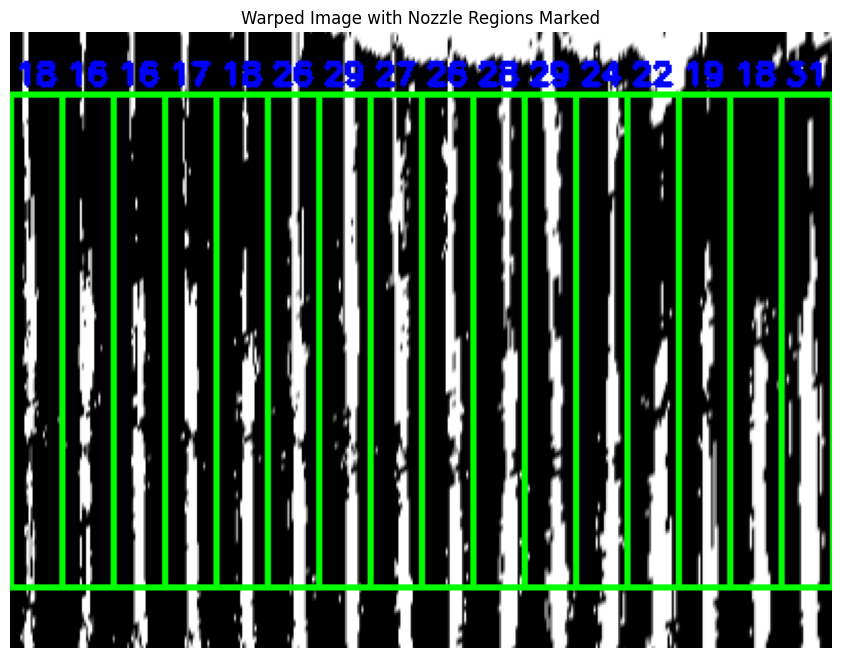

Nozzle 1: White Pixel Ratio = 0.19
Nozzle 2: White Pixel Ratio = 0.16
Nozzle 3: White Pixel Ratio = 0.17
Nozzle 4: White Pixel Ratio = 0.18
Nozzle 5: White Pixel Ratio = 0.19
Nozzle 6: White Pixel Ratio = 0.26
Nozzle 7: White Pixel Ratio = 0.29
Nozzle 8: White Pixel Ratio = 0.28
Nozzle 9: White Pixel Ratio = 0.26
Nozzle 10: White Pixel Ratio = 0.29
Nozzle 11: White Pixel Ratio = 0.29
Nozzle 12: White Pixel Ratio = 0.24
Nozzle 13: White Pixel Ratio = 0.22
Nozzle 14: White Pixel Ratio = 0.20
Nozzle 15: White Pixel Ratio = 0.19
Nozzle 16: White Pixel Ratio = 0.32


In [6]:
# Set parameters for dividing the warped image into nozzle areas
num_nozzles = 16
width = warped_image.shape[1]
height = warped_image.shape[0]

# Calculate the width of each nozzle region based on the number of nozzles
nozzle_width = width // num_nozzles
white_ratios = []

# Loop through each nozzle region and calculate the white pixel ratio excluding 10% top and 15% bottom
for i in range(num_nozzles):
    # Define the region for the current nozzle
    x_start = i * nozzle_width
    x_end = (i + 1) * nozzle_width if (i + 1) < num_nozzles else width

    y_start = int(0.10 * height)
    y_end = int(0.9 * height)
    nozzle_region = warped_image[y_start:y_end, x_start:x_end]

    # Ensure nozzle_region is single-channel (convert if necessary)
    if len(nozzle_region.shape) == 3:
        nozzle_region = cv2.cvtColor(nozzle_region, cv2.COLOR_BGR2GRAY)

    # Calculate the white pixel ratio in the current nozzle region
    white_pixels = cv2.countNonZero(nozzle_region)
    total_pixels = nozzle_region.size
    white_ratio = white_pixels / total_pixels if total_pixels > 0 else 0
    white_ratios.append(white_ratio)

if len(warped_image.shape) == 2: 
    warped_image_color = cv2.cvtColor(warped_image, cv2.COLOR_GRAY2BGR)
else:
    warped_image_color = warped_image

# Display the warped image with regions marked for each nozzle and add percentage text
for i in range(num_nozzles):
    x_start = i * nozzle_width
    x_end = (i + 1) * nozzle_width if (i + 1) < num_nozzles else width
    y_start = int(0.10 * height)
    y_end = int(0.9 * height)

    # Draw a rectangle representing the analyzed region (excluding 10% top and 15% bottom)
    cv2.rectangle(warped_image_color, (x_start, y_start), (x_end, y_end), (0, 255, 0), 2)

    # Add the calculated white pixel ratio as a small number on the image with different color based on value
    text_value = int(white_ratios[i] * 100)  # Convert ratio to percentage as an integer
    text_color = (0,0,204) if white_ratios[i] <= 0.15 else (255,0,0)  # Red if <= 0.2
    text_position = (x_start + 2, y_start - 5 )
    cv2.putText(warped_image_color, f"{text_value}", text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(warped_image_color, cv2.COLOR_BGR2RGB))
plt.title("Warped Image with Nozzle Regions Marked")
plt.axis('off')
plt.show()

# Print the calculated white ratios for each nozzle region
for i, ratio in enumerate(white_ratios):
    print(f"Nozzle {i+1}: White Pixel Ratio = {ratio:.2f}")
